Function takes a dict of patient dataframes
Create Sliding Window feature vectors or some many of feature vectors
Add Engineered features

RunLGBM

Eval outputs

Grid Search - Machine Learning library to run 10k combos with json input

In [39]:
import os
from pprint import pprint
import pandas as pd

import lgbm_pipeline.feature_load as loader

patients: list[pd.DataFrame] = loader.load_training_data("../training_set?/*.psv")
print(len(patients))

Loading PSV Files: 100%|██████████| 40336/40336 [03:06<00:00, 216.27it/s] 


40336


In [40]:
import lgbm_pipeline.feature_extraction as extractor
patients_forward = extractor.fill(patients, extractor.FillMethod.FORWARD)
patients_backwards = extractor.fill(patients, extractor.FillMethod.BACKWARD)
patients_linear = extractor.fill(patients, extractor.FillMethod.LINEAR)

In [41]:
patients_with_fill_methods: dict[extractor.FillMethod, list[pd.DataFrame]] = {extractor.FillMethod.FORWARD: patients_forward,
                              extractor.FillMethod.BACKWARD: patients_backwards,
							  extractor.FillMethod.LINEAR: patients_linear}
all_patients_mixed = extractor.mixed_fill(patients_with_fill_methods)

# create sliding window of feature vectors
windows = []
for key, val in all_patients_mixed.items():
	val.index = pd.to_timedelta(val.index, 'h')
	windows.append(val.rolling("6h").mean())

In [56]:
import lightgbm as lgbm
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

X = all_patients_mixed.drop("SepsisLabel", axis="columns", inplace=False)
y = all_patients_mixed["SepsisLabel"]

X_train, X_val, y_train, y_val = train_test_split(X, y)
clf = xgb.XGBClassifier(eval_metric=fbeta_score)
bst = clf.fit(X_train, y_train)

[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    380898
           1       0.89      0.18      0.30      7155

    accuracy                           0.98    388053
   macro avg       0.94      0.59      0.65    388053
weighted avg       0.98      0.98      0.98    388053



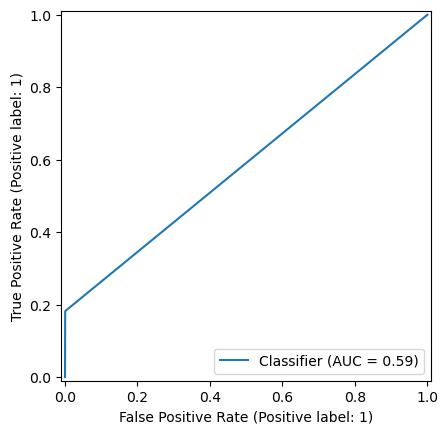

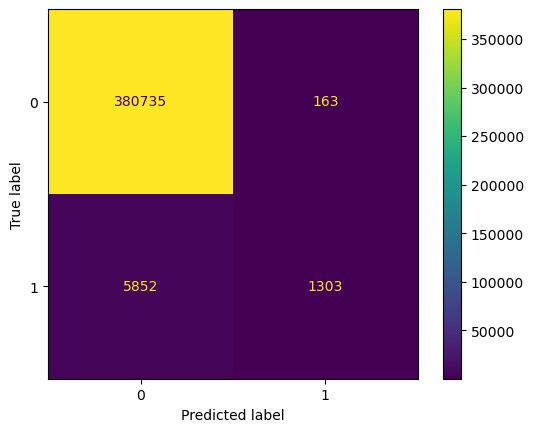

In [53]:
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, classification_report

y_pred = bst.predict(X_val)
print(y_pred)
RocCurveDisplay.from_predictions(y_val, y_pred)
ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
print(classification_report(y_val, y_pred))

In [54]:
from collections import Counter
pprint(Counter(y_train))
pprint(Counter(y_val))
pprint(Counter(y_pred))

Counter({0: 1143396, 1: 20761})
Counter({0: 380898, 1: 7155})
Counter({0: 386587, 1: 1466})
